# Clustering Comparison

***These codes are imported from Scikit-Learn python package for learning purpose***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### 1. Comparing different clustering algorithms on toy datasets

This example aims at showing characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. The last dataset is an example of a 'null'
situation for clustering: the data is homogeneous, and
there is no good clustering.

While these examples give some intuition about the algorithms,
this intuition might not apply to very high dimensional data.

The results could be improved by tweaking the parameters for
each clustering strategy, for instance setting the number of
clusters for the methods that needs this parameter
specified. Note that affinity propagation has a tendency to
create many clusters. Thus in this example its two parameters
(damping and per-point preference) were set to mitigate this
behavior.


-----------

In [2]:
import time
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

#### Data

In [3]:
np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']



#### Cluster Comparison

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:478: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral em

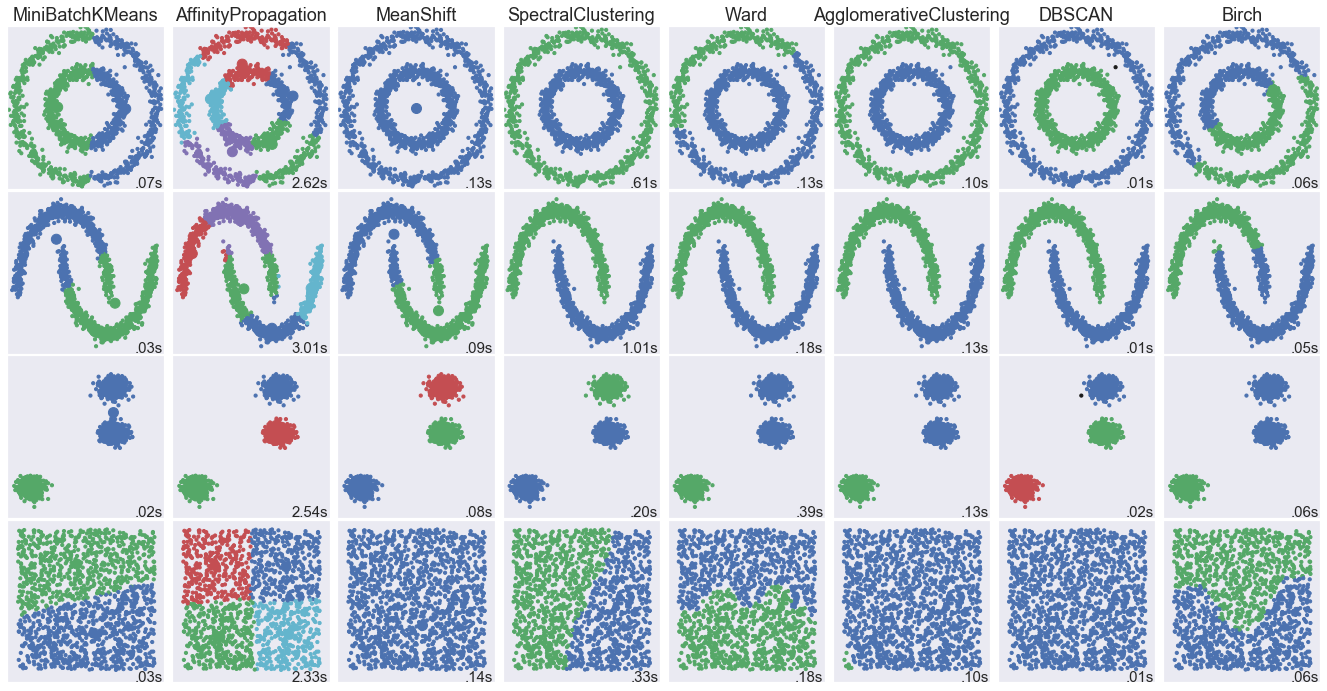

In [4]:
plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=2)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


-----------------

### Comparison of the K-Means and MiniBatchKMeans clustering algorithms

We want to compare the performance of the MiniBatchKMeans and KMeans:
the MiniBatchKMeans is faster, but gives slightly different results (see
:ref:`mini_batch_kmeans`).

We will cluster a set of data, first with KMeans and then with
MiniBatchKMeans, and plot the results.
We will also plot the points that are labelled differently between the two
algorithms.


In [19]:
import time
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs

 #### Data

In [20]:
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

 #### Kmeans

In [21]:
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

 #### MiniBatchKMeans

In [22]:
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

 #### Plot

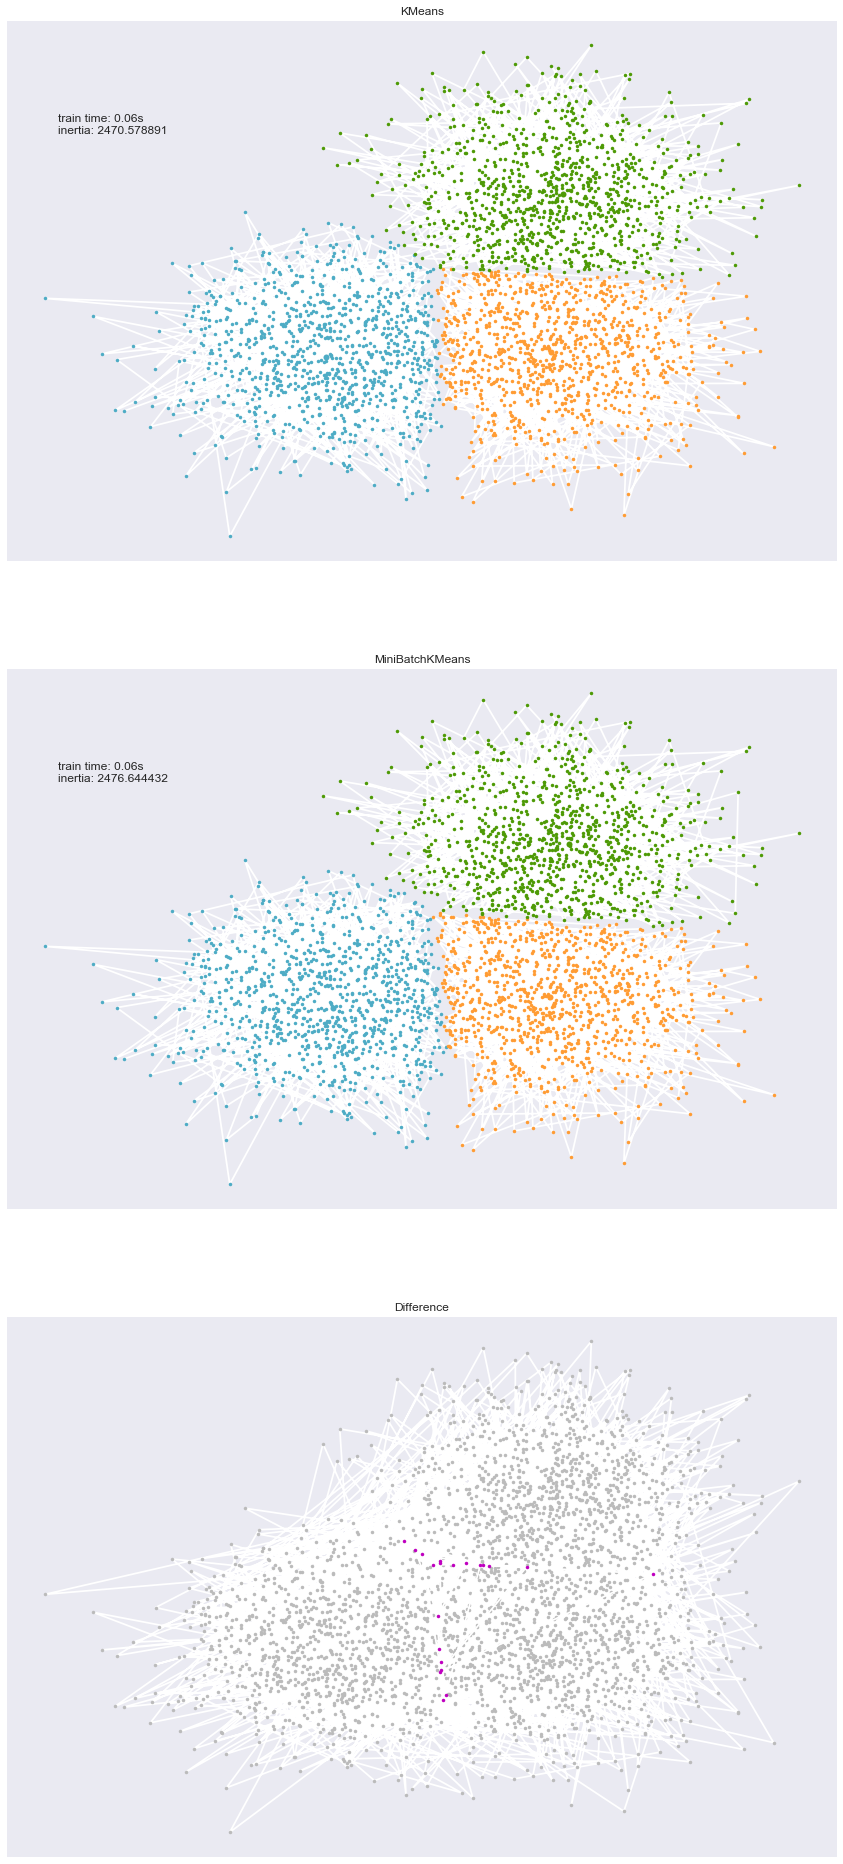

In [23]:
# Plot result

fig = plt.figure(figsize=(12, 30))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = np.sort(k_means.cluster_centers_, axis=0)
mbk_means_cluster_centers = np.sort(mbk.cluster_centers_, axis=0)
k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)
order = pairwise_distances_argmin(k_means_cluster_centers,
                                  mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(3, 1, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(3, 1, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == order[k]
    cluster_center = mbk_means_cluster_centers[order[k]]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(3, 1, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == order[k]))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())
plt.show()


------------

### 3. Compare BIRCH and MiniBatchKMeans

--------------

This example compares the timing of Birch (with and without the global
clustering step) and MiniBatchKMeans on a synthetic dataset having
100,000 samples and 2 features generated using make_blobs.

If ``n_clusters`` is set to None, the data is reduced from 100,000
samples to a set of 158 clusters. This can be viewed as a preprocessing
step before the final (global) clustering step that further reduces these
158 clusters to 100 clusters.


* Authors: Manoj Kumar <manojkumarsivaraj334@gmail.com Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
* License: BSD 3 clause


In [14]:
from itertools import cycle
from time import time
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs

#### Data

In [16]:
# Generate centers for the blobs so that it forms a 10 X 10 grid.
xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centres = np.hstack((np.ravel(xx)[:, np.newaxis],
                       np.ravel(yy)[:, np.newaxis]))

# Generate blobs to do a comparison between MiniBatchKMeans and Birch.
X, y = make_blobs(n_samples=100000, centers=n_centres, random_state=0)
   

# Use all colors that matplotlib provides by default.
colors_ = cycle(colors.cnames.keys())

#### Result

Birch without global clustering as the final step took 5.98 seconds
n_clusters : 158
Birch with global clustering as the final step took 6.06 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 5.78 seconds


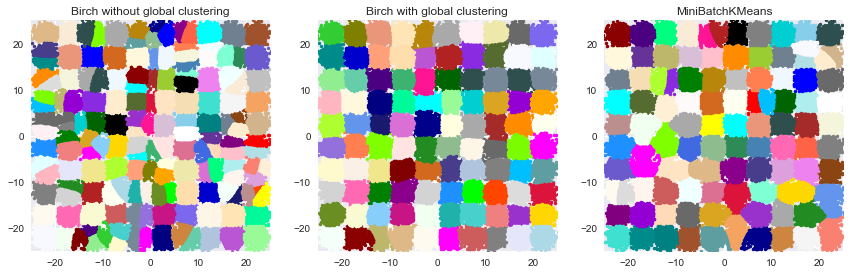

In [17]:
fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# Compute clustering with Birch with and without the final clustering step
# and plot.
birch_models = [Birch(threshold=1.7, n_clusters=None),
                Birch(threshold=1.7, n_clusters=100)]
final_step = ['without global clustering', 'with global clustering']


for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    time_ = time() - t
    print("Birch %s as the final step took %0.2f seconds" % (
          info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.plot(X[mask, 0], X[mask, 1], 'w',
                markerfacecolor=col, marker='.')
        if birch_model.n_clusters is None:
            ax.plot(this_centroid[0], this_centroid[1], '+', markerfacecolor=col,
                    markeredgecolor='k', markersize=5)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title('Birch %s' % info)

# Compute clustering with MiniBatchKMeans.
mbk = MiniBatchKMeans(init='k-means++', n_clusters=100, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
print("Time taken to run MiniBatchKMeans %0.2f seconds" % t_mini_batch)
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_,
                                 range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=col, marker='.')
    ax.plot(this_centroid[0], this_centroid[1], '+', markeredgecolor='k',
            markersize=5)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()


------------------------